<a href="https://colab.research.google.com/github/Kotarosz727/my_python/blob/main/05_%E6%A5%AD%E5%8B%99%E8%A6%81%E4%BB%B6%E3%81%A8%E5%87%A6%E7%90%86%E3%83%91%E3%82%BF%E3%83%BC%E3%83%B3_%E5%96%B6%E6%A5%AD%E6%88%90%E7%B4%84%E4%BA%88%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**営業成約予測(分類）**  
・モデルが成功の見込みありと予測した顧客に対して実際どの程度成功するか＝「適合率」

In [1]:
# データの読み込みと確認

In [39]:
# 余分なワーニングを非表示にする
import warnings
warnings.filterwarnings('ignore')
# matplotlib日本語化対応
# import japanize_matplotlib

In [2]:
import pandas as pd

df_all = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bank-full.csv', sep=';')
df_all.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [3]:
columns = [
    '年齢', '職業', '婚姻', '学歴', '債務不履行', '平均残高',
    '住宅ローン', '個人ローン', '連絡手段', '最終通話日',
    '最終通話月', '最終通話秒数', '通話回数_販促中',
    '前回販促後_経過日数', '通話回数_販促前', '前回販促結果',
    '今回販促結果'
]
df_all.columns = columns
df_all.head()

,年齢,職業,婚姻,学歴,債務不履行,平均残高,住宅ローン,個人ローン,連絡手段,最終通話日,最終通話月,最終通話秒数,通話回数_販促中,前回販促後_経過日数,通話回数_販促前,前回販促結果,今回販促結果
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
print(df_all.shape)
print()

print(df_all['今回販促結果'].value_counts())
print()

rate = df_all['今回販促結果'].value_counts()['yes']/len(df_all)
print(rate)

(45211, 17)

no     39922
yes     5289
Name: 今回販促結果, dtype: int64

0.11698480458295547


In [5]:
# 欠損値の確認
print(df_all.isnull().sum())

年齢            0
職業            0
婚姻            0
学歴            0
債務不履行         0
平均残高          0
住宅ローン         0
個人ローン         0
連絡手段          0
最終通話日         0
最終通話月         0
最終通話秒数        0
通話回数_販促中      0
前回販促後_経過日数    0
通話回数_販促前      0
前回販促結果        0
今回販促結果        0
dtype: int64


In [6]:
# データ前処理と分割

In [7]:
# テキスト型をOne-hotエンコーディング
def enc(df, column):
  df_dummy = pd.get_dummies(df[column], prefix=column)
  df = pd.concat([df.drop([column], axis=1),df_dummy], axis=1)
  return df

df_all2 = df_all.copy()
df_all2 = enc(df_all2, '職業')
df_all2 = enc(df_all2, '婚姻')
df_all2 = enc(df_all2, '学歴')
df_all2 = enc(df_all2, '連絡手段')
df_all2 = enc(df_all2, '前回販促結果')

df_all2.head()

,年齢,債務不履行,平均残高,住宅ローン,個人ローン,最終通話日,最終通話月,最終通話秒数,通話回数_販促中,前回販促後_経過日数,通話回数_販促前,今回販促結果,職業_admin.,職業_blue-collar,職業_entrepreneur,職業_housemaid,職業_management,職業_retired,職業_self-employed,職業_services,職業_student,職業_technician,職業_unemployed,職業_unknown,婚姻_divorced,婚姻_married,婚姻_single,学歴_primary,学歴_secondary,学歴_tertiary,学歴_unknown,連絡手段_cellular,連絡手段_telephone,連絡手段_unknown,前回販促結果_failure,前回販促結果_other,前回販促結果_success,前回販促結果_unknown
0,58,no,2143,yes,no,5,may,261,1,-1,0,no,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
1,44,no,29,yes,no,5,may,151,1,-1,0,no,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1
2,33,no,2,yes,yes,5,may,76,1,-1,0,no,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,47,no,1506,yes,no,5,may,92,1,-1,0,no,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1
4,33,no,1,no,no,5,may,198,1,-1,0,no,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1


In [8]:
# yes/noをバイナリに変換
def enc_bin(df, column):
  df[column] = df[column].map(dict(yes=1, no=0))
  return df

df_all2 = enc_bin(df_all2, '債務不履行')
df_all2 = enc_bin(df_all2, '住宅ローン')
df_all2 = enc_bin(df_all2, '個人ローン')
df_all2 = enc_bin(df_all2, '今回販促結果')

df_all2.head(10)  

,年齢,債務不履行,平均残高,住宅ローン,個人ローン,最終通話日,最終通話月,最終通話秒数,通話回数_販促中,前回販促後_経過日数,通話回数_販促前,今回販促結果,職業_admin.,職業_blue-collar,職業_entrepreneur,職業_housemaid,職業_management,職業_retired,職業_self-employed,職業_services,職業_student,職業_technician,職業_unemployed,職業_unknown,婚姻_divorced,婚姻_married,婚姻_single,学歴_primary,学歴_secondary,学歴_tertiary,学歴_unknown,連絡手段_cellular,連絡手段_telephone,連絡手段_unknown,前回販促結果_failure,前回販促結果_other,前回販促結果_success,前回販促結果_unknown
0,58,0,2143,1,0,5,may,261,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
1,44,0,29,1,0,5,may,151,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1
2,33,0,2,1,1,5,may,76,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,47,0,1506,1,0,5,may,92,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1
4,33,0,1,0,0,5,may,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1
5,35,0,231,1,0,5,may,139,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
6,28,0,447,1,1,5,may,217,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1
7,42,1,2,1,0,5,may,380,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1
8,58,0,121,1,0,5,may,50,1,-1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1
9,43,0,593,1,0,5,may,55,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1


In [9]:
# 月をintに変換
month_dict = dict(jan=1, feb=2, mar=3, apr=4, may=5, jun=6, jul=7, aug=8, sep=9, oct=10, nov=11, dec=12)

def enc_month(df, column):
  df[column] = df[column].map(month_dict)
  return df

df_all2 = enc_month(df_all2, '最終通話月')

df_all2.head()

,年齢,債務不履行,平均残高,住宅ローン,個人ローン,最終通話日,最終通話月,最終通話秒数,通話回数_販促中,前回販促後_経過日数,通話回数_販促前,今回販促結果,職業_admin.,職業_blue-collar,職業_entrepreneur,職業_housemaid,職業_management,職業_retired,職業_self-employed,職業_services,職業_student,職業_technician,職業_unemployed,職業_unknown,婚姻_divorced,婚姻_married,婚姻_single,学歴_primary,学歴_secondary,学歴_tertiary,学歴_unknown,連絡手段_cellular,連絡手段_telephone,連絡手段_unknown,前回販促結果_failure,前回販促結果_other,前回販促結果_success,前回販促結果_unknown
0,58,0,2143,1,0,5,5,261,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
1,44,0,29,1,0,5,5,151,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1
2,33,0,2,1,1,5,5,76,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,47,0,1506,1,0,5,5,92,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1
4,33,0,1,0,0,5,5,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1


In [10]:
# データ分割

In [11]:
# 入力と正解に分割
x = df_all2.drop('今回販促結果', axis=1)
y = df_all2['今回販促結果'].values
print(x)
print(y)

       年齢  債務不履行  平均残高  ...  前回販促結果_other  前回販促結果_success  前回販促結果_unknown
0      58      0  2143  ...             0               0               1
1      44      0    29  ...             0               0               1
2      33      0     2  ...             0               0               1
3      47      0  1506  ...             0               0               1
4      33      0     1  ...             0               0               1
...    ..    ...   ...  ...           ...             ...             ...
45206  51      0   825  ...             0               0               1
45207  71      0  1729  ...             0               0               1
45208  72      0  5715  ...             0               1               0
45209  57      0   668  ...             0               0               1
45210  37      0  2971  ...             1               0               0

[45211 rows x 37 columns]
[0 0 0 ... 1 0 0]


In [12]:
# 訓練と検証に分割
test_size = 0.4

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=1)

In [13]:
# アルゴリズムの選択

In [14]:
# 複数のアルゴリズムで精度を比較
def prepare_algorithms(random_seed):
  # 線形回帰
  from sklearn.linear_model import LogisticRegression
  algorithm1 = LogisticRegression(random_state=random_seed)

  # サポートベクターマシン（カーネル）
  # from sklearn.svm import SVC
  # algorithm2 = SVC(kernel='rbf', random_state=random_seed)

  # 決定木
  from sklearn.tree import DecisionTreeClassifier
  algorithm2 = DecisionTreeClassifier(random_state=random_seed)

  # ランダムフォレスト
  from sklearn.ensemble import RandomForestClassifier
  algorithm3 = RandomForestClassifier(random_state=1)

  # XGBoost
  from xgboost import XGBClassifier
  algorithm4 = XGBClassifier(random_state=random_seed)

  algorithms = [algorithm1, algorithm2, algorithm3, algorithm4]
  return algorithms

In [15]:
# 交差検定法を用いて最適なアルゴリズムを選択
# from sklearn.model_selection import StratifiedKFold
# stratifiedKFold = StratifiedKFold(n_splits=3)

# from sklearn.model_selection import cross_val_score
# for algorithm in prepare_algorithms(1):
#   scores = cross_val_score(algorithm, x_train, y_train, cv=stratifiedKFold, scoring='roc_auc')
#   score = scores.mean()
#   name = algorithm.__class__.__name__
#   print(f'mean: {score:.4f} each: {scores} {name}')

In [16]:
# 学習・予測・評価

In [17]:
# XGBoostを使用
from xgboost import XGBClassifier
algorithm = XGBClassifier(random_state=1)

In [18]:
algorithm.fit(x_train, y_train)

XGBClassifier(random_state=1)

In [19]:
y_pred = algorithm.predict(x_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [20]:
# 評価

# confusion_matrix
def custom_confusion_matrix(matrix, columns):
  n = len(columns)

  act = ['正解データ'] * n
  pred = ['予測結果'] * n

  cm = pd.DataFrame(matrix, columns=[pred, columns], index=[act, columns])
  return cm

from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, y_pred)
df_matrix = custom_confusion_matrix(matrix, ['失敗', '成功'])
df_matrix

予測結果     
             失敗   成功
正解データ 失敗  15602  385
      成功   1320  778

In [21]:
# 適合率、再現率、F値の計算コード
from sklearn.metrics import precision_recall_fscore_support

precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f'適合率: {precision:.4f}')
print(f'再現率: {recall:.4f}')
print(f'F値: {fscore:.4f}')

適合率: 0.6690
再現率: 0.3708
F値: 0.4772


In [23]:
# チューニング

In [34]:
# 確率値の度数分布グラフ
import seaborn as sns
import matplotlib.pyplot as plt


# y=0の確率値取得
y_proba0 = algorithm.predict_proba(x_test)[:, 1]
# print(algorithm.predict_proba(x_test))
print(y_proba0)

[0.00979258 0.01957677 0.4234032  ... 0.11795481 0.0086364  0.12085684]


In [26]:
y0 = y_proba0[y_test==0]
y1 = y_proba0[y_test==1]

print(y0)
print()
print(y1)

[0.00979258 0.01957677 0.4234032  ... 0.016337   0.0086364  0.12085684]

[0.533731   0.11956514 0.68884397 ... 0.7656943  0.00592741 0.11795481]


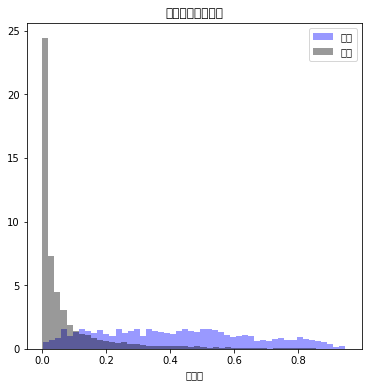

In [37]:
plt.figure(figsize=(6,6))
plt.title('確率値の度数分布')
sns.distplot(y1, kde=False, norm_hist=True, bins=50, color='b', label='成功')
sns.distplot(y0, kde=False, norm_hist=True, bins=50, color='k', label='失敗')
plt.xlabel('確率値')
plt.legend()

In [ ]:
# 閾値を変更した場合の予測関数の定義
def pred(algorithm, x, thres):
  y_proba = algorithm.predict_proba(x)

  # 予測結果1の確率
  y_proba1 = y_proba[:,1]

  y_pred = (y_proba1 > thres).astype(int)
  return y_pred